**This is exploration of the BigG (Trucking company dataset). The trucks have a complete stop if they have the spn-code of 5246, spn-1569 and fmi 31 is 75% derate. The objectiv eis to figure out the spn/fmi codde combination withi 3-6 hour window to call the truck from the road and save the cost of toweing and have the delivery on time using alternative.**

**Data code**
**QCVehDiagOnboardData –**
 
Id -  the record Id
Name – the name of the diagnostic
Value – the value for that diagnostic
FaultId – foreign key to the QCJ1939Fault record

 
These are the engine data parameters that are sent with the engine faults.
 
**QCJ1939Fault –**
 
**ESS_Id** – the event subscriber service event that contained the fault
**EventTimeStamp** – when the event took place
**eventDescription** – brief text of meaning of the code (not always present)
**actionDescription** – never seen this filled in
**ecuSoftwareVersion** – version string from the reporting vehicle computer system
**ecuSerialNumber** – Serial number of the reporting Engine Control Module (ECM)
**ecuModel** -Model of the reporting ECM
**ecuMake** – Manufacturer of the reporting ECM
**ecuSource** –
**spn** – Fault code being reported
**fmi** – Failure Mode associated with the Fault Code
**active**– whether the code is being set or being removed
**activeTransitionCount** – Number of times code has been set/unset
**faultValue** – never seen used
**EquipmentID** – Assigned truck number of the unit in question
**MCTNumber**– Communications Terminal assigned to the truck
**Latitude** – Latitude at time of event
**Longitude** – Longitude at time of event
**LocationTimeStamp** – Time latitude and longitude were obtained


In [2]:
#Libraries need for work

import pandas as pd
from datetime import datetime



from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#we need to create a conda environment for pycaret and then pip install the packages after activating and rerun the notebook.
# from pycaret.classification import *
# from pycaret.regression import *
# from pycaret.time_series import *

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [4]:
#Reading the data files

faults = pd.read_csv("../data/J1939Faults.csv",low_memory=False,
                     parse_dates=['EventTimeStamp', 'LocationTimeStamp'])
    #initial reading we saw it has date time object so we will keep them as date time. 
    #Also we saw the waning for memmory because of which we were loosing observations, so we will have low_memmory =False

diagnostic = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")
service = pd.read_excel("../data/Service Fault Codes_1_0_0_167.xlsx")

C:\Users\upadh\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


**Looking for data structure in the read csv**

In [7]:
faults.shape #(1187335, 20)
diagnostic.shape #(12821626, 4)
service.shape #service.shape #

(7124, 14)

In [8]:
faults.head(2)

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25
1,2,990360,2015-02-21 11:34:34,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10


In [9]:
faults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   ESS_Id                 1187335 non-null  int64         
 2   EventTimeStamp         1187335 non-null  datetime64[ns]
 3   eventDescription       1126490 non-null  object        
 4   actionDescription      0 non-null        float64       
 5   ecuSoftwareVersion     891285 non-null   object        
 6   ecuSerialNumber        844318 non-null   object        
 7   ecuModel               1122577 non-null  object        
 8   ecuMake                1122577 non-null  object        
 9   ecuSource              1187335 non-null  int64         
 10  spn                    1187335 non-null  int64         
 11  fmi                    1187335 non-null  int64         
 12  active                 11873

In [12]:
faults.describe()
faults.isna().sum()

RecordID                       0
ESS_Id                         0
EventTimeStamp                 0
eventDescription           60845
actionDescription        1187335
ecuSoftwareVersion        296050
ecuSerialNumber           343017
ecuModel                   64758
ecuMake                    64758
ecuSource                      0
spn                            0
fmi                            0
active                         0
activeTransitionCount          0
faultValue               1187335
EquipmentID                    0
MCTNumber                      0
Latitude                       0
Longitude                      0
LocationTimeStamp              0
dtype: int64

<Axes: title={'center': 'Observations_per_year'}, ylabel='Number of Observations'>

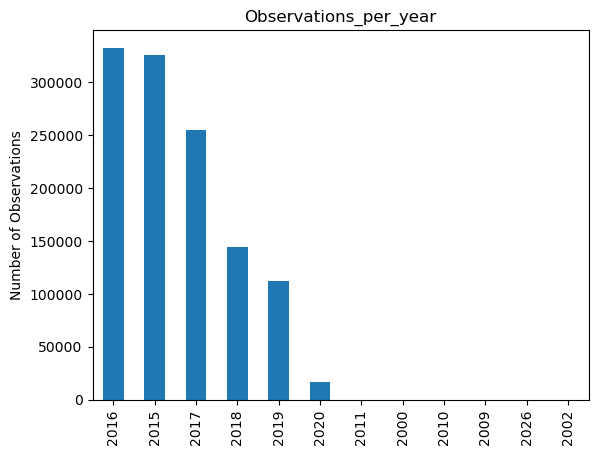

In [33]:
faults.columns
faults['EventTimeStamp'].value_counts()
(faults['EventTimeStamp']
 .dt.year
 .value_counts()
 .sort_values(ascending = False)
 .plot(kind="bar", 
       title = 'Observations_per_year',
       xlabel='', ylabel='Number of Observations'))
#date time has year dt.year extracts year from it

<Axes: title={'center': 'Observations_per_year'}, ylabel='Number of Observations'>

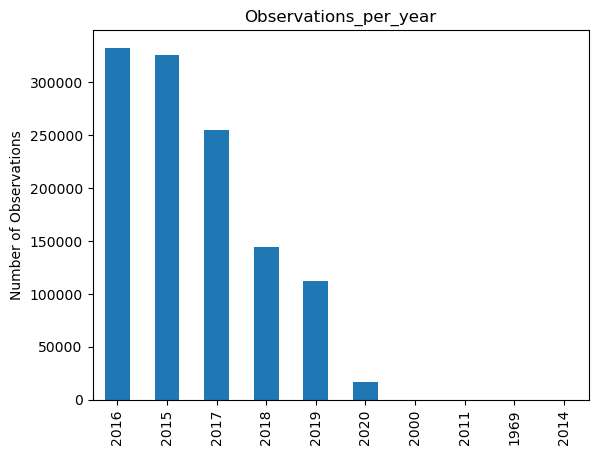

In [34]:
(faults['LocationTimeStamp']
 .dt.year
 .value_counts()
 .sort_values(ascending = False)
 .plot(kind="bar", 
       title = 'Observations_per_year',
       xlabel='',
       ylabel='Number of Observations'))
#date time has year dt.year extracts year from it

In [35]:
faults['EventTimeStamp'].dt.year.unique()
faults['EventTimeStamp'].dt.year.value_counts()
faults['LocationTimeStamp'].dt.year.value_counts()

2016    332403
2015    325826
2017    254923
2018    144578
2019    112204
2020     17198
2000       192
2011         8
1969         2
2014         1
Name: LocationTimeStamp, dtype: int64

<Axes: title={'center': 'Equipment_Id'}, ylabel='Number of Observations'>

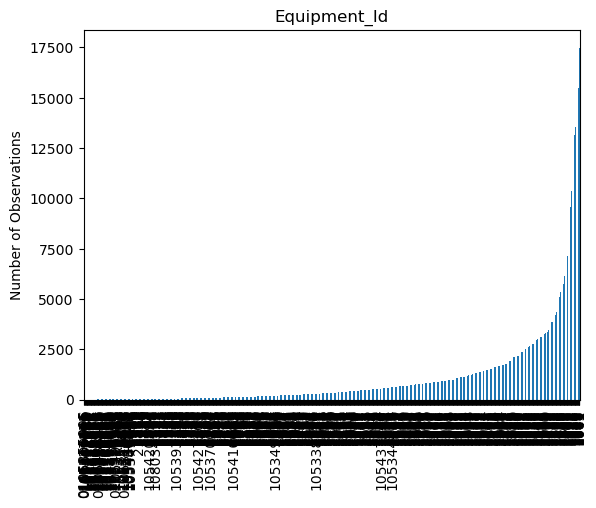

In [55]:
faults['EquipmentID'].nunique() #1122
(faults['EquipmentID'].value_counts().sort_values()
 .plot(kind="bar", 
       title = 'Equipment_Id',
       xlabel= (''),
       ylabel='Number of Observations'))

In [61]:
#the EuipmentId is a string character and has length varrying from character lnrth 3 4, 5, and 9 and 10
faults['EquipmentID'].str.len().nunique() #5
faults['EquipmentID'].str.len().value_counts().sort_values(ascending=False).to_frame()


,EquipmentID
4,1158964
3,26179
9,2150
5,23
10,19


In [63]:
faults['active'].value_counts()

True     608454
False    578881
Name: active, dtype: int64

In [ ]:
faults['spn'].nunique() #450
faults['fmi'].nunique() #26
faults[(faults['spn'] == 1569)].shape #10927 observations
faults[(faults['spn'] == 5246)].shape #1195 observations

faults.groupby('EquipmentID')[(faults['spn'] == 1569)]

**SUMMARY faults df:**

It has 1187335 (1.18 X10^6) obseravtions and 20 features.
The columns are ['RecordID', 'ESS_Id', 'EventTimeStamp', 'eventDescription',
       'actionDescription', 'ecuSoftwareVersion', 'ecuSerialNumber',
       'ecuModel', 'ecuMake', 'ecuSource', 'spn', 'fmi', 'active',
       'activeTransitionCount', 'faultValue', 'EquipmentID', 'MCTNumber',
       'Latitude', 'Longitude', 'LocationTimeStamp']
We have following structure two datetime (EventTimeStamp,  LocationTimeStamp), Object (ecuSoftwareVersion,ecuSerialNumber, ecuModel,  ecuMake, EquipmentID )
we have 4 floats including Latitite and Longitude but the actionDescription and faultValue  are all null 
**so we will drop actionDescription and faultValue columns.**
Rest are all int64.

0   RecordID               1187335 non-null  int64         
 1   ESS_Id                 1187335 non-null  int64         
 2   EventTimeStamp         1187335 non-null  datetime64[ns]
 3   eventDescription       1126490 non-null  object        
 4   actionDescription      0 non-null        float64       
 5   ecuSoftwareVersion     891285 non-null   object        
 6   ecuSerialNumber        844318 non-null   object        
 7   ecuModel               1122577 non-null  object        
 8   ecuMake                1122577 non-null  object        
 9   ecuSource              1187335 non-null  int64         
 10  spn                    1187335 non-null  int64         
 11  fmi                    1187335 non-null  int64         
 12  active                 1187335 non-null  bool          
 13  activeTransitionCount  1187335 non-null  int64         
 14  faultValue             0 non-null        float64       
 15  EquipmentID            1187335 non-null  object        
 16  MCTNumber              1187335 non-null  int64         
 17  Latitude               1187335 non-null  float64       
 18  Longitude              1187335 non-null  float64       
 19  LocationTimeStamp      1187335 non-null  datetime64[ns]
    
The event starts at **[ 2000, 2002, 2009,2010, 2011, 2015, 2016, 2017, 2018, 2019,  2020, 2026]**,
but the 2011(244),2000(219),2010(58), 2009(24),2026(3),2002(1) have a total of 541 observations. 

**in the LocationTimeStamp we also have 2014(1),2000(192), 2011(8), 1969(2)
**So we will drop the years below 2014.**

We have a total of 1122 unique EquipmentID. The string character is of 5 different length most observations are of string character of 3 and 4 there are also some 5 but then we have 9 and 10.
As mentioned by the BigG  **we will drop the id which more than 5 character.**

The lat and long column will be used for finding how close the truck is one of the three servce stations.
**One degree of latitude equals approximately 364,000 feet (69 miles). One-degree of longitude equals 288,200 feet (54.6 miles)**
so **we will drop those observations which are within 1 mile radii of the service station.**

Also the **active** code which are **False** means that the fault code is fixed so we will also drop those rows.
The lat long of the three stations are also provided.

There 450 uniues spn codes.

***cleaning the faults the df***

In [ ]:
#finding the distance from the nearest service stations

